# Sentiment Analysis for MySejahtera App
### Group members : 
### Ong Horng Neng (S2191604) , Devayani a/p Balkrishnan (22056764), Oscar Looi Koon Seng (S2174066), Tan Jun Ren (22050099), Teo Kwee Kim (S2181984)

# Modelling

## Content
- [Import Libraries](#Import-Libraries)
- [Data Dictionary](#Data-Dictionary)
- [Load Data](#Load-Data)
- [Modeling](#Modeling)
    - [Classical Machine Learning](#Classical-Machine-Learning)
      - [Model Selection](#Model-Selection)
      - [Test Design](#Test-Design)
      - [Model Development](#Model-Development)
      - [Model Assessment](#Model-Assessment)
      - [Misclassified Reviews on Validation Set](#Misclassified-Reviews-on-Validation-Set)
      - [Evaluate Production Model on Test Set](#Evaluate-Production-Model-on-Test-Set)
         - [Misclassified Reviews in the Test Set](#Misclassified-Reviews-on-the-Test-Set)
    - [Long Short-Term Memory (LSTM)](#Long-Short-Term-Memory-(LSTM))
- [Topic Modeling for Negative Sentiment](#Topic-Modeling-for-Negative-Sentiment)


## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Libraries for classical machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score

# Libraries for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Libraries for topic modeling
from pprint import pprint
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

%matplotlib inline

In [3]:
pd.set_option('display.max_colwidth', None)

## Data Dictionary

An overview of the features in our dataset.

| Feature     	| Type 	| Description                                                       	|
|:-------------	|:------	|:-------------------------------------------------------------------	|
| content     	| obj  	| Raw text containing user reviews                                  	|
| content_stem 	| obj  	| Pre-processed text for modeling                                   	|
| score       	| int  	| No. of star ratings the user gave (1-5)                           	|
| target      	| int  	| Target variable <br>Postive sentiment: 0<br>Negative sentiment: 1 	|

## Load Data

Load in MySejahtera's Google Play reviews that we have collected, cleaned and pre-processed.

In [4]:
# basic configurations for 2 experiments (dataset file, result file)
exps = {
     "e1": ('dataset_experiment_1.csv', 'result1.csv'),
     "e2": ('dataset_experiment_2.csv', 'result2.csv'),
      #"e1": ('experiment1_dataset.csv', 'result1.csv'),
      #"e2": ('experiment2_dataset.csv', 'result2.csv'),
}

exp_file1, result_file1 = exps["e1"]
exp_file2, result_file2 = exps["e2"]

In [5]:
# load from dataset files
exp_dataset1 = pd.read_csv(exp_file1)
exp_dataset2 = pd.read_csv(exp_file2)

## Model Selection

We will explore both classical machine learning and deep learning (LSTM) for sentiment analysis. The production model will be selected based on accuracy and recall on the validation set.

### Classical Machine Learning

We will use the Bag of Words (BoW) representation to extract features from the text. This will be done through vectorization, specifically the CountVectorizer and TF-IDF Vectorizer. The CountVectorizer simply tokenizes and counts the word occurrences in our corpus. While on the other hand, TF-IDF tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

After vectorizing, we will fit a Logistic Regression, K-NN, Decision Tree,Support Vector Machine Random Forest, XGBoost and Multinomial Naive Bayes on the training data and evaluate the models' performance on the validation set.

## Test Design

In [6]:
# Assign features and targets
X1 = exp_dataset1["content_stem"]
y1 = exp_dataset1['target']
X2 = exp_dataset2["content_stem"]
y2 = exp_dataset2['target']

# Splits to training and test sets
# Experiment 1  - data set with positive 0 index 5<=x<=3, 1 index 2<=x<=1
# Negative reviews: 1-star, 2-star, positive reviews: 3-star, 4-star, 5-star
# Negative: 1, positive: 0
# Test_size: 0.2, Validation_set: 0.3, Training_set: 0.5
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1) 
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.375, random_state=42, stratify=y_train1)

# Experiment 2 - dataset with positive 0 index 5<=x<=4, 1 index 3=<x<=1
# Negative reviews: 1-star, 2-star, 3-star, positive reviews: 4-star, 5-star
# Negative: 1, positive: 0
# Test_size: 0.2, Validation_set: 0.3, Training_set: 0.5
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.375, random_state=42, stratify=y_train2)

# Assign into lists for convenience later
exps = [
    ("exp1", result_file1, X_train1, X_val1, X_test1, y_train1, y_val1, y_test1),
    ("exp2", result_file2, X_train2, X_val2, X_test2, y_train2, y_val2, y_test2),
]

#print(X_train1.shape, X_val1.shape, X_test1.shape)

In [7]:
X_train1.shape,X_val1.shape,y_train1.value_counts(normalize=True)

((3767,),
 (2261,),
 0    0.618529
 1    0.381471
 Name: target, dtype: float64)

In [8]:
X_train2.shape,X_val2.shape,y_train2.value_counts(normalize=True)

((3767,),
 (2261,),
 1    0.580834
 0    0.419166
 Name: target, dtype: float64)

In [9]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english') 
cvec_df = pd.DataFrame(cvec.fit_transform(X_train2).todense(), columns=cvec.get_feature_names_out())
cvec_df.shape

(3767, 3719)

There are 3719 unique words in our corpus.

## Model Development

In [10]:
# Create a classification report   
def creport(actual_y, predictions, dataset):
    print('Classification report for', dataset)
    report = classification_report(actual_y, predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv('classification_report.csv', mode='a', index=False) 
    print(classification_report(actual_y, predictions))
    print('')
          
# Create a confusion matrix 
def cmat(actual_y, predictions, dataset):
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], 
                         index=['Actual Positive Review', 'Actual Negative Review'])
    print('Confusion matrix for', dataset)
    print(cm_df)

In [11]:
random_state=10
cvec_max_features = [800]
cvec_min_df = [2,3]
cvec_max_df = [.9,.95]
tvec_max_features = [800]
tvec_min_df = [2,3]
tvec_max_df = [.9,.95]

# get count vectorizer in tuples (name, vectorizer, params) 
def get_count_vectorizer():
    return ("cvec", CountVectorizer(stop_words="english"), {
        'cvec__max_features': cvec_max_features,
        'cvec__min_df': cvec_min_df, 
        'cvec__max_df': cvec_max_df, 
    })

# get tfidf vectorizer in tuples (name, vectorizer, params)
def get_tfidf_vectorizer():
    return ("tvec", TfidfVectorizer(stop_words='english'), {
    'tvec__max_features': tvec_max_features,
    'tvec__min_df': tvec_min_df,
    'tvec__max_df': tvec_max_df, 
    })

# get both count vectorizer and tfidf vectorizer
def get_vectorizers():
    return [
        get_count_vectorizer(),
        get_tfidf_vectorizer()
    ]

# get classifiers in tuples (name, algorithms, params)
def get_classifiers():
    return [
          ("lr", LogisticRegression(random_state=random_state), {"lr__penalty": ["l2"], "lr__C": [.01,.1]}), # Logistics Regression
          ("knn", KNeighborsClassifier(), {"knn__n_neighbors": [5,10,15,20]}), # K Nearest Neighbors
          ('dt', DecisionTreeClassifier(random_state=random_state), {}), # Decision Tree
          ('svc', SVC(random_state=random_state), {'svc__kernel': ['linear'],'svc__C': [1]}), # Support Vector Classifier
          ('rf', RandomForestClassifier(random_state=random_state), {}), # Random Forest
          ('xgb', xgb.XGBClassifier(), {}), # XGBoost
          ('mnb', MultinomialNB(), {}) # Multinomial Naive Bayes
    ]

In [12]:
# 3 nested loops:
# for each experiments,
#   for each vectorizers
#      for each classifiers
#         do training (fitting), store time taken

fitted_models = []
vectorizers = get_vectorizers()
classifiers = get_classifiers()

for exp_type, result_csv, X_train, X_val, X_test, y_train, y_val, y_test in exps:
    print(" " * 0, "=" * 10, exp_type, "=" * 10)
    for vec_pipeline_name, vectorizer, vec_params in vectorizers:
        print(" " * 1, "_" * 10, vec_pipeline_name, "_" * 10)
        for classifier_pipeline_name, classifier, classifier_params in classifiers:
            print(" " * 2, "=" * 10, classifier_pipeline_name, "=" * 10)
            start = time.time()
            
            # Form vectorizer - classifier names for logging purpose
            vectorizer_classifier_name = f"{vec_pipeline_name}_{classifier_pipeline_name}"
            
            # Step 1: form Pipeline with vectorizers and classifiers
            pipeline = Pipeline([
                (vec_pipeline_name, vectorizer), 
                (classifier_pipeline_name, classifier)]
            )
            params = {**vec_params, **classifier_params}
            
            # Step 2: form model with GridSearchCV
            model = GridSearchCV(pipeline, param_grid=params, cv=10)
            
            # Step 3: fit train datasets into models
            model.fit(X_train, y_train)
            
            # Logging
            end = time.time()
            time_taken = end-start
            fitted_models.append((exp_type, result_csv, vectorizer_classifier_name, model, time_taken, 
                                  X_train, y_train,
                                  X_val, y_val,
                                  X_test, y_test))
            
            print(" " * 2, f"best param: {model.best_params_}")
            print(" " * 2, f"Best score: {model.best_score_:.5f}")
            print(" " * 2, vectorizer_classifier_name, f"has been fitted ({time_taken:.2f}s)")

print("=" * 10, "Ok. Models fitted", "=" * 10)

 ========== exp1 ==========
  __________ cvec __________
   ========== lr ==========
   best param: {'cvec__max_df': 0.9, 'cvec__max_features': 800, 'cvec__min_df': 3, 'lr__C': 0.1, 'lr__penalty': 'l2'}
   Best score: 0.71808
   cvec_lr has been fitted (8.93s)
   ========== knn ==========
   best param: {'cvec__max_df': 0.9, 'cvec__max_features': 800, 'cvec__min_df': 2, 'knn__n_neighbors': 5}
   Best score: 0.64560
   cvec_knn has been fitted (21.52s)
   ========== dt ==========
   best param: {'cvec__max_df': 0.9, 'cvec__max_features': 800, 'cvec__min_df': 2}
   Best score: 0.66842
   cvec_dt has been fitted (15.08s)
   ========== svc ==========
   best param: {'cvec__max_df': 0.9, 'cvec__max_features': 800, 'cvec__min_df': 3, 'svc__C': 1, 'svc__kernel': 'linear'}
   Best score: 0.70454
   cvec_svc has been fitted (80.10s)
   ========== rf ==========
   best param: {'cvec__max_df': 0.9, 'cvec__max_features': 800, 'cvec__min_df': 3}
   Best score: 0.72312
   cvec_rf has been fitted (14

## Model Assessment

In [13]:
# for each fitted models
#   do predict, and get accuracy, recall score
#   print classification report and confusion matrix
# then store results into csv

results = []

print(len(fitted_models))

for (exp_type, result_csv, vectorizer_classifier_name, model, time_taken,
    X_train, y_train, X_val, y_val, X_test, y_test) in fitted_models: 
    y_pred_train = model.predict(X_train).round()
    score_acc_train = accuracy_score(y_pred_train, y_train)
    score_recall_train = recall_score(y_pred_train, y_train)
    
    y_pred_val = model.predict(X_val).round()
    score_acc_val = accuracy_score(y_pred_val, y_val)
    score_recall_val = recall_score(y_pred_val, y_val)
    
    y_pred_test = model.predict(X_test).round()
    score_acc_test = accuracy_score(y_pred_test, y_test)
    score_recall_test = recall_score(y_pred_test, y_test)
    
    print(vectorizer_classifier_name, f"Training score: {model.score(X_train, y_train):.5f}")
    print(vectorizer_classifier_name, f"Validation score: {model.score(X_val, y_val):.5f}")
    print(vectorizer_classifier_name, f"Test score: {model.score(X_test, y_test):.5f}")
    print(exp_type, "val", "=", vectorizer_classifier_name, f"Accuracy: {score_acc_val:.5f}, Recall: {score_recall_val:.5f}")
    
    creport(y_val, y_pred_val, "val")
    cmat(y_val, y_pred_val, "val")
    results.append((exp_type, result_csv, vectorizer_classifier_name, 
                    score_acc_train, score_recall_train, score_acc_val, score_recall_val,
                    score_acc_test, score_recall_test,
                    time_taken))

for (exp_type, result_csv, vectorizer_classifier_name, 
    score_acc_train, score_recall_train, score_acc_val, score_recall_val,
    score_acc_test, score_recall_test,
    time_taken) in results:
    d = {
        "exp \t": [f"{exp_type}\t"],
        "vec_clf\t": [f"{vectorizer_classifier_name}\t"],
        "acc train\t": [f"{score_acc_train:.5f}\t"],
        "rec train\t": [f"{score_recall_train:.5f}\t"],
        "acc val\t": [f"{score_acc_val:.5f}\t"],
        "rec val\t": [f"{score_recall_val:.5f}\t"],
        "acc test\t": [f"{score_acc_test:.5f}\t"],
        "rec test\t": [f"{score_recall_test:.5f}\t"],
        "time\t": [f"{time_taken:.2f}\t"]
    } 
        
    df = pd.DataFrame(d)
    header = not os.path.isfile(result_csv)
    df.to_csv(result_csv, mode='a', index=False, header=header)
    
print("=" * 10, "Ok. Models evaluated.", "=" * 10)

28
cvec_lr Training score: 0.78444
cvec_lr Validation score: 0.72357
cvec_lr Test score: 0.72149
exp1 val = cvec_lr Accuracy: 0.72357, Recall: 0.67401
Classification report for val
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1399
           1       0.67      0.53      0.59       862

    accuracy                           0.72      2261
   macro avg       0.71      0.69      0.69      2261
weighted avg       0.72      0.72      0.72      2261


Confusion matrix for val
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                       1177                        222
Actual Negative Review                        403                        459
cvec_knn Training score: 0.74914
cvec_knn Validation score: 0.64750
cvec_knn Test score: 0.63859
exp1 val = cvec_knn Accuracy: 0.64750, Recall: 0.55200
Classification report for val
              precision    recall  f1-score   support

tvec_rf Training score: 0.98274
tvec_rf Validation score: 0.72888
tvec_rf Test score: 0.73939
exp1 val = tvec_rf Accuracy: 0.72888, Recall: 0.65428
Classification report for val
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1399
           1       0.65      0.61      0.63       862

    accuracy                           0.73      2261
   macro avg       0.71      0.71      0.71      2261
weighted avg       0.73      0.73      0.73      2261


Confusion matrix for val
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                       1120                        279
Actual Negative Review                        334                        528
tvec_xgb Training score: 0.92567
tvec_xgb Validation score: 0.72092
tvec_xgb Test score: 0.71419
exp1 val = tvec_xgb Accuracy: 0.72092, Recall: 0.65503
Classification report for val
              precision    recall  f1-score   support

 

tvec_knn Training score: 0.81364
tvec_knn Validation score: 0.66077
tvec_knn Test score: 0.67706
exp2 val = tvec_knn Accuracy: 0.66077, Recall: 0.65116
Classification report for val
              precision    recall  f1-score   support

           0       0.70      0.34      0.45       948
           1       0.65      0.90      0.75      1313

    accuracy                           0.66      2261
   macro avg       0.68      0.62      0.60      2261
weighted avg       0.67      0.66      0.63      2261


Confusion matrix for val
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        318                        630
Actual Negative Review                        137                       1176
tvec_dt Training score: 0.97345
tvec_dt Validation score: 0.68819
tvec_dt Test score: 0.71021
exp2 val = tvec_dt Accuracy: 0.68819, Recall: 0.74796
Classification report for val
              precision    recall  f1-score   support

 

The 2 tables below provide an overview of the models' performance by accuracy and recall on the validation set for Experiment 1 and Experiment 2.

### Experiment 1

|                                                             		| Accuracy on Training Set 	| Accuracy on Validation Set| Recall on Validation Set     	| 
|:-------------------------------------------------------------	-	|:-------------------------:|:-------------------------:|:----------------------------:	|
| Count Vectorizer & Linear Regression                              | 0.78444                   | 0.72357                   | 0.67401                      	| 
| Count Vectorizer & K Nearest Neighbor                             | 0.74914                   | 0.64750                   | 0.55200                      	| 
| Count Vectorizer & Decision Tree                                  | 0.98328                   | 0.65812                   | 0.55121                      	| 
| Count Vectorizer & Support Vector Machine                         | 0.84258                   | 0.72136                   | 0.64758                     	| 
| Count Vectorizer & Random Forest                                  | 0.98301                   | 0.71473                   | 0.62177                      	| 
| Count Vectorizer & XGBoost                                        | 0.89355                   | 0.72667                   | 0.66095                     	|
| Count Vectorizer & Multinomial Naive Bayes                        | 0.75577                   | 0.72225                   | 0.62745                      	| 
| TF-IDF Vectorizer & Logistic Regression                           | 0.71065                   | 0.69659                   | 0.69820                      	| 
| TF-IDF Vectorizer & K Nearest Neighbor                            | 0.65915                   | 0.63246                   | 0.62602                     	| 
| TF-IDF Vectorizer & Decision Tree                                 | 0.98274                   | 0.65856                   | 0.55528                     	| 
| TF-IDF Vectorizer & Support Vector Machine                        | 0.80966                   | 0.73330                   | 0.65546                      	| 
| TF-IDF Vectorizer & Random Forest                                 | 0.98274                   | 0.72888                   | 0.65428                      	| 
| TF-IDF Vectorizer & XGBoost                                       | 0.92567                   | 0.72092                   | 0.65503                      	| 
| TF-IDF Vectorizer & Multinomial Naive Bayes                       | 0.76400                   | 0.72180                   | 0.64879                     	|

### Experiment 2

|                                                            	| Accuracy on Training Set 	| Accuracy on Validation Set| Recall on Validation Set     	| 
|:-------------------------------------------------------------	|:-------------------------:|:-------------------------:|:----------------------------:	|
| Count Vectorizer & Linear Regression                       	| 0.81285                  	| 0.76426                   | 0.77046                      	| 
| Count Vectorizer & K Nearest Neighbor                        	| 0.75763                  	| 0.64839                   | 0.73675                      	| 
| Count Vectorizer & Decision Tree                             	| 0.97345                  	| 0.67669                   | 0.74745                      	| 
| Count Vectorizer & Support Vector Machine                    	| 0.85745                  	| 0.73375                   | 0.76629                      	| 
| Count Vectorizer & Random Forest                             	| 0.97345                  	| 0.76205                   | 0.77155                      	| 
| Count Vectorizer & XGBoost                                   	| 0.88426                  	| 0.75763                   | 0.76145                      	|
| Count Vectorizer & Multinomial Naive Bayes                   	| 0.76905                  	| 0.74613                   | 0.79774                      	| 
| TF-IDF Vectorizer & Logistic Regression                      	| 0.75259                  	| 0.73994                   | 0.71137                      	| 
| TF-IDF Vectorizer & K Nearest Neighbor                        | 0.81364                  	| 0.66077                   | 0.65116                      	| 
| TF-IDF Vectorizer & Decision Tree                            	| 0.97345                  	| 0.68819                   | 0.74796                      	| 
| TF-IDF Vectorizer & Support Vector Machine                   	| 0.82559                  	| 0.75409                   | 0.76340                     	| 
| TF-IDF Vectorizer & Random Forest                            	| 0.97345                  	| 0.75542                   | 0.76723                      	| 
| TF-IDF Vectorizer & XGBoost                                  	| 0.91426                  	| 0.75409                   | 0.76085                      	| 
| TF-IDF Vectorizer & Multinomial Naive Bayes                  	| 0.78975                  	| 0.76471                   | 0.77251                      	|

The Multinomial Naive Bayes was selected as our production model as it achieved the highest accuracy (0.76471) and recall on the validation set (0.77251). The performance of most machine learning algorithms in Experiment 1 is poorer than Experiment 2. Hence, in general 3-star reviews contains more negative sentiment than positive. 

Next, we will cover more in-depth assessments for Experiment 2 in terms of Misclassified Reviews on Validation Set, Evaluate Production Model on Test Set, Misclassified Reviews on Test Set and Topic Modelling.

### Misclassified Reviews on Validation Set

Let's have a look at the misclassified reviews to understand the limitations in our production model.

In [20]:
models = [(model, X_val, y_val, X_test, y_test) 
          for exp_type, result_csv, vectorizer_classifier_name, model, time_taken,
          X_train, y_train, X_val, y_val, X_test, y_test 
           in fitted_models if vectorizer_classifier_name == "tvec_mnb" and exp_type == "exp2"]
model, X_val, y_val, X_test, y_test = models[0]

# Create a dataframe for only the validation data
val_df = exp_dataset2.loc[y_val.index, :] 
val_df['pred'] = model.predict(X_val)


In [21]:
# Create a column to indicate if the review was correctly predicted
val_df['correctly_classified'] = (val_df['pred'] == val_df['target'])

In [22]:
val_df[val_df['correctly_classified']==0].shape

(532, 18)

In [23]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
# 0 = positive, 1 = negative
val_df[(val_df['target']==0) & (val_df['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
5122,I don't want to enable Bluetooth /location at all time because that drain battery quickly.,want enabl bluetooth locat time drain batteri quickli,4,0,1
6185,"A bit slow on the transition from front page to the QR code camera. But then, it might be just my phone. I just wish that all info from the CPRC from telegram are in this, eg. Clusters report.",bit slow transit front page qr code camera might phone wish info cprc telegram eg cluster report,5,0,1
5402,Unable to submit HAT,unabl submit hat,4,0,1
7160,Very helpful.,help,5,0,1
7163,Fantastic,fantast,5,0,1
...,...,...,...,...,...
6190,"Please have mysejahtera ""lite"" version for old phones (old OS 4.3/4.4 etc.) from 2013/2014, Error message: ""Unfortunately mysejahtera has stopped"" after uninstalled last year's version and downloaded version 41 (29/7/21) on 1/8/21 then version 42 (2/8/21) on 3/8/21 with still the same problem (can't open mysejahtera app). Please fix.",pleas lite version old phone old os etc error messag unfortun stop uninstal last year version download version version still problem open pleas fix,5,0,1
5931,My SJ trace is too sensitive. I get more interactions in traffic jams than at work,sj trace sensit get interact traffic jam work,4,0,1
6531,I am using both TNG eWallet and MySejahtera apps. I applied for ePenjana but was advised that my particulars were NOT SIMILAR !! I re-installed both apps BUT still receive that NOT SIMILAR advice ! I need guidance on HOW TO OVERCOME THIS PROBLEM URGENTLY. TQ.,use tng ewallet app appli epenjana advis particular similar instal app still receiv similar advic need guidanc overcom problem urgent tq,5,0,1
6843,"Salam, we need to the updated version to get the certificate in PDF file for Android mobiles, we not have this option yet. Tq",salam need updat version get certif pdf file android mobil option yet tq,5,0,1


In [24]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
# 0 = positive, 1 = negative
val_df[(val_df['target']==1) & (val_df['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
2634,Good,good,2,1,0
3487,1)Some time it doesnt update immediately the place you ve checked in. 2) Laminated bar code that glared by the sun gets pretty hard to scan. 3) Need fast internet and phone spec for a quick check in,time doesnt updat immedi place check lamin bar code glare sun get pretti hard scan need fast internet phone spec quick check,3,1,0
1947,"Not all better experience as I dislike the application was logged out; the user may lost the info before, and not very suitable for emergency moment to every user.",better experi dislik applic log user may lost info suitabl emerg moment everi user,2,1,0
3862,good,good,3,1,0
1070,good apps,good app,1,1,0
...,...,...,...,...,...
3068,This app should have red dot on the maps to show if there has been any new covid reported cases within 14 days. Or a month. In the specific location. Instead of just show there has been a new cases reported within 1 km. People should know how many cases reported within their areas to spread awareness. And to avoid the location with high cases,red dot map show new covid report case within day month specif locat instead show new case report within km peopl know mani case report within area spread awar avoid locat high case,3,1,0
680,"Quite poorly developed, not user friendly & have much to be improved on. Considering the large amount of budget that went into this, must be a joke. SUGGESTION: Add a feature to filter out locations which we may have not checked out yet as we are human we may forget, OR categorise the check ins to malls, shoplots, etc so it can auto check out with different check ins, or at least notify u. DON'T EVEN GET ME STARTED ON THE VACCINATION DATES, NO NOTIFICATIONS, MAKE IT USER FRIENDLY FOR THE ELDERLY",quit poorli develop user friendli much improv consid larg amount budget went must joke suggest add featur filter locat may check yet human may forget categoris check in mall shoplot etc auto check differ check in least notifi u even get start vaccin date notif make user friendli elderli,1,1,0
4126,Convenient to use.,conveni use,3,1,0
826,I'm using Samsung Flip3 device and cannot scan QR code to check in. I need to scan few time only able to detect the QR code. Whereby other model Samsung mobile phone no such issue. Please fix this problem as I believe your application display resolution may not fully compatible with certain model out there.,use samsung flip devic cannot scan qr code check need scan time abl detect qr code wherebi model samsung mobil phone issu pleas fix problem believ applic display resolut may fulli compat certain model,1,1,0


Now, that we have looked through the false positives and false negatives. We will identify the top most frequently occuring words to explain the misclassifications.

In [25]:
# Plot a barplot of the top 20 most frequently occuring words in misclassified reviews

def barplot_tvec(df, pred, title, color):
    words_series = df[(df['correctly_classified']==0) & (df['pred']==pred)]['content_stem']
    
    # Instantiate TF-IDF Vectorizer 
    tvec = TfidfVectorizer(stop_words='english')
    
    # Save the tokens in a dataframe
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).todense(), columns=tvec.get_feature_names_out())
    sum_words = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    
    # Chart aesthetics
    plt.title(title, size=15, weight='bold')
    plt.xlabel('Count', size=12)
    plt.xlim(0,25)
    plt.yticks(size=12)
    plt.tight_layout()

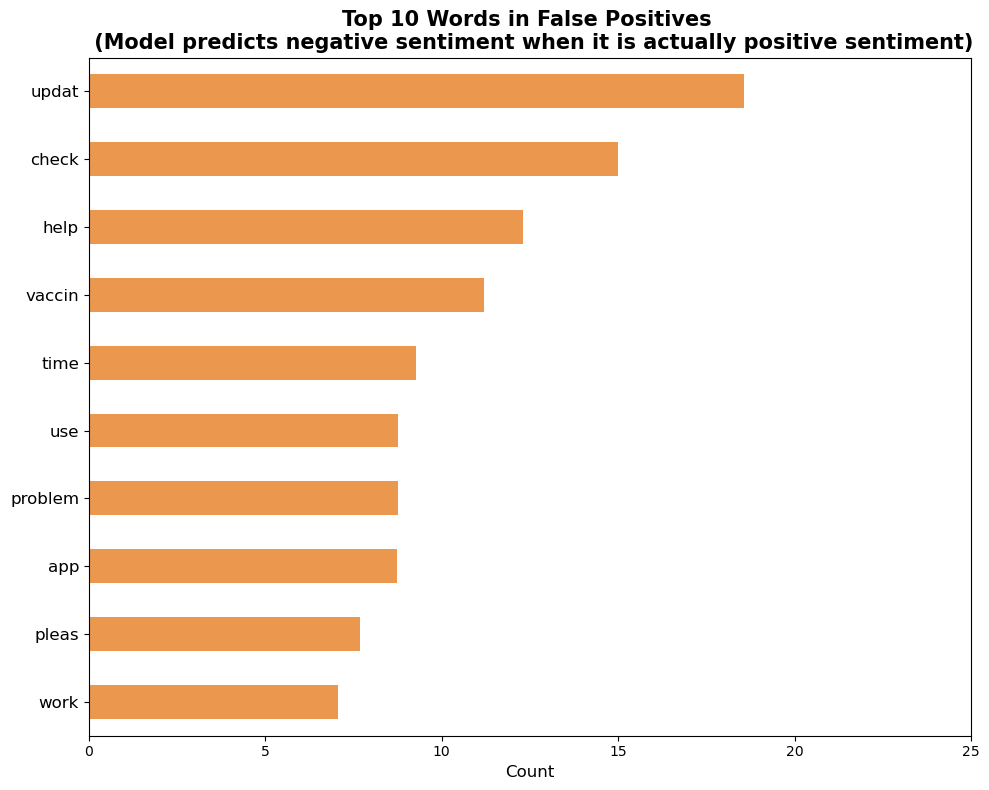

In [26]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=val_df,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#EB984E')

In [27]:
# False Negatives
fn = val_df[(val_df['correctly_classified']==0) & (val_df['pred']==0)][['content','content_stem','score']]

In [28]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

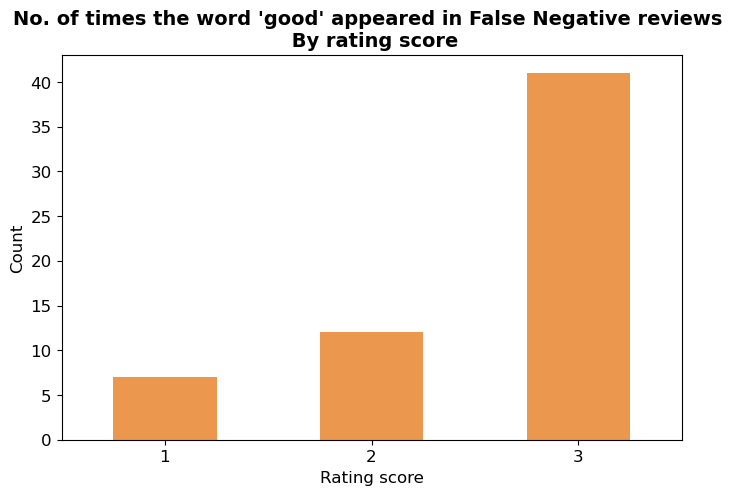

In [29]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

We observe that there are quite a few users who wrote reviews with the word 'good' in them, yet gave the app a rating of 3. Since the model has been trained to believe that the word 'good' belongs to a positive sentiment, the model has thus predicted these to be positive reviews. Hence, misclassifications happen as a result of fence-sitters writing reviews that have positive connotation.

In [30]:
pd.set_option('display.max_colwidth', None)

# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','score']]

,content,score
2634,Good,2
3862,good,3
1070,good apps,1
4125,So far so good,3
4146,Good,3
4180,Well...good,3
4304,I believe still good and need more improvement day by day.,3
3240,A good app that can better.. Can have a start up in scan mode toggle option in settings so less one tap to achieve the main function? Open app straight scan ready.,3
3346,"Good for our own safety but I dislike the loading system... It's too wasting my time when I need hurry up to enter any place. Sometime, it's quickly scanning, sometime it's slow...please fix it!",3
3507,App is fine. Although the newly added checkout function doesn't serve a purpose. Quite useless frankly. Adding a tedious feature on an otherwise pretty good app.,3


### Evaluate Production Model on Test Set

Finally, we will evaluate our model's performance on the test set.

In [31]:
models = [(model, X_val, y_val, X_test, y_test) 
          for exp_type, result_csv, vectorizer_classifier_name, model, time_taken, 
          X_train, y_train, X_val, y_val, X_test, y_test 
           in fitted_models if vectorizer_classifier_name == "tvec_mnb" and exp_type == "exp2"]
model, X_val, y_val, X_test, y_test = models[0]

# Generate predictions on test set
test_pred = model.predict(X_test2)

In [32]:
print('Evaluation metrics for test set')
print('')
print('Accuracy score: ', accuracy_score(y_test2, test_pred))
print('Recall score: ', recall_score(y_test2, test_pred))
print('')

# Print classification report and confusion matrix
cmat(y_test2, test_pred, 'test set')
creport(y_test2, test_pred, 'test set')

Evaluation metrics for test set

Accuracy score:  0.7751989389920424
Recall score:  0.860730593607306

Confusion matrix for test set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        415                        217
Actual Negative Review                        122                        754
Classification report for test set
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       632
           1       0.78      0.86      0.82       876

    accuracy                           0.78      1508
   macro avg       0.77      0.76      0.76      1508
weighted avg       0.77      0.78      0.77      1508




Given that our production model Multinomial Naive Bayes achieves 0.7752 on accuracy and 0.8607 on recall, we can conclude that the model generalises well on unseen data.

### Misclassified Reviews in the Test Set

Let us have a look at the misclassifications in our test set.

In [33]:
# Generate predictions on the test set
models = [(model, X_val, y_val, X_test, y_test) 
          for exp_type, result_csv, vectorizer_classifier_name, model, time_taken, 
          X_train, y_train, X_val, y_val, X_test, y_test 
           in fitted_models if vectorizer_classifier_name == "tvec_mnb" and exp_type == "exp2"]
model, X_val, y_val, X_test, y_test = models[0]

# Create a dataframe for only the validation data
test = exp_dataset2.loc[y_test.index, :] 
test['pred'] = model.predict(X_test)


In [34]:
# Create a column to indicate if the review was correctly predicted
test['correctly_classified'] = (test['pred'] == test['target'])

In [35]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
test[(test['target']==0) & (test['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
6594,"Don't know why I couldn't update to the latest version. My app shows updated by when I open the app, its still the same old interface.",know updat latest version show updat open still old interfac,5,0,1
5911,UNABLE to UPDATE MySJ Trace after updating this app.. kindly assist. TQ,unabl updat mysj trace updat kindli assist tq,4,0,1
6989,Very satisfactory,satisfactori,5,0,1
4993,"I got my vaccine digital certificate. It can show my digital qr code but suddenly after update, it's not working. Nothing happend when i click on show qr on my digital certificate",got vaccin digit certif show digit qr code suddenli updat work noth happend click show qr digit certif,4,0,1
6040,Comfortable user interface but as of 3/11/2020 the feature that tells me how many patients are in the vicinity doesn't update often enough to reflect the number of active cases at any given time. Otherwise it's fairly usable.,comfort user interfac featur tell mani patient vicin updat often enough reflect number activ case given time otherwis fairli usabl,5,0,1
...,...,...,...,...,...
4523,"Downloaded last month. Not user friendly for registeration. Downloaded again after PM announced to have this app downloaded. Registration is successful. Received confirmation via e-mail, but unable to log in. Receiving error message 'Invalid login ID'. There's a serious technical problem with this app. Very poor quality.",download last month user friendli register download pm announc download registr success receiv confirm via e mail unabl log receiv error messag invalid login id seriou technic problem poor qualiti,4,0,1
5503,no OTP sent to my phone! fix your app,otp sent phone fix,4,0,1
5357,Please consider deleting the check out button. No ones bother to check out places the heck,pleas consid delet check button one bother check place heck,4,0,1
6453,"This app are the best health and safety monitor. But i think there a lack of security. My suggestion are one IC Number or passport number can be only register with one id only. A bit of security concern when we can register many time using same ID Number or Passport. By the way, congratulation of providing this aps. Actually i have issued the matter to helpdesk regarding my old id cannot be access and my whole data of vaccination not included in my new id.",best health safeti monitor think lack secur suggest one ic number passport number regist one id bit secur concern regist mani time use id number passport way congratul provid ap actual issu matter helpdesk regard old id cannot access whole data vaccin includ new id,5,0,1


In [36]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
test[(test['target']==1) & (test['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
1819,App is slow when loading and why not implement the Google exposure notification feature? The feature can detect anyone that have Covid-19 positive nearby.,slow load implement googl exposur notif featur featur detect anyon covid posit nearbi,2,1,0
2989,Saying that the system needs improvement is calling the sky blue. The app itself works well. But not for older people. Navigating the registration system and information seems to be enough of a labyrinth for older people. Rule #4 Good design makes a product understandable. Rule #5 Good design is unobtrusive.,say system need improv call sky blue work well older peopl navig registr system inform seem enough labyrinth older peopl rule good design make product understand rule good design unobtrus,3,1,0
3226,"I am a MySejahtera user. But as a premise owner i'd like to know who is coming in and out of of my premise. This app helps us for the scanning features. But i think it would be more better and useful if the government put an attendance database system into this app. Everytime user scan the QR code and the info name and contact number will be recorded in the system, this shall be helpful for the us the premise owner to trace people who comes in and out of the premise on daily basis.",user premis owner like know come premis help us scan featur think would better use govern put attend databas system everytim user scan qr code info name contact number record system shall help us premis owner trace peopl come premis daili basi,3,1,0
4170,There are things can be improved.,thing improv,3,1,0
3596,"Hope to get multilingual app. There're only English and Malay. Hope the app developers will add more language in it, such Mandarin, Tamil and so on.",hope get multilingu english malay hope develop add languag mandarin tamil,3,1,0
...,...,...,...,...,...
1625,"Poor auto focus since recent update on my mobile. Im unable to scan recenlty. no button to enable focus, a feature u need to enable click to focus. Since this development team is paid to create by govt. I hope they will stop using opensource zxing team's barcode scanner out of the box and use paid version or develop a good barcode scanner themself. This open source is good but u need to enhance it to adapt to various models of mobile. Esp auto focus which ur app is stuck using 1/2 lens i have",poor auto focu sinc recent updat mobil im unabl scan recenlti button enabl focu featur u need enabl click focu sinc develop team paid creat govt hope stop use opensourc zxing team barcod scanner box use paid version develop good barcod scanner themself open sourc good u need enhanc adapt variou model mobil esp auto focu ur stuck use len,2,1,0
4030,Very good,good,3,1,0
3644,Whats the point of having mysejahtera with bluetooth when you still allow people to write in the books? You can have 10 person writing on the books with only 5 people scan in mysejahtera.,what point bluetooth still allow peopl write book person write book peopl scan,3,1,0
3744,"How accurate this app can help if person come in contact with Covid 19 case ? There is only check in time , there is no check out time Also will be great if my trace app is incorporated to this app , which will help the Government to make the tracing more accurate",accur help person come contact covid case check time check time also great trace incorpor help govern make trace accur,3,1,0


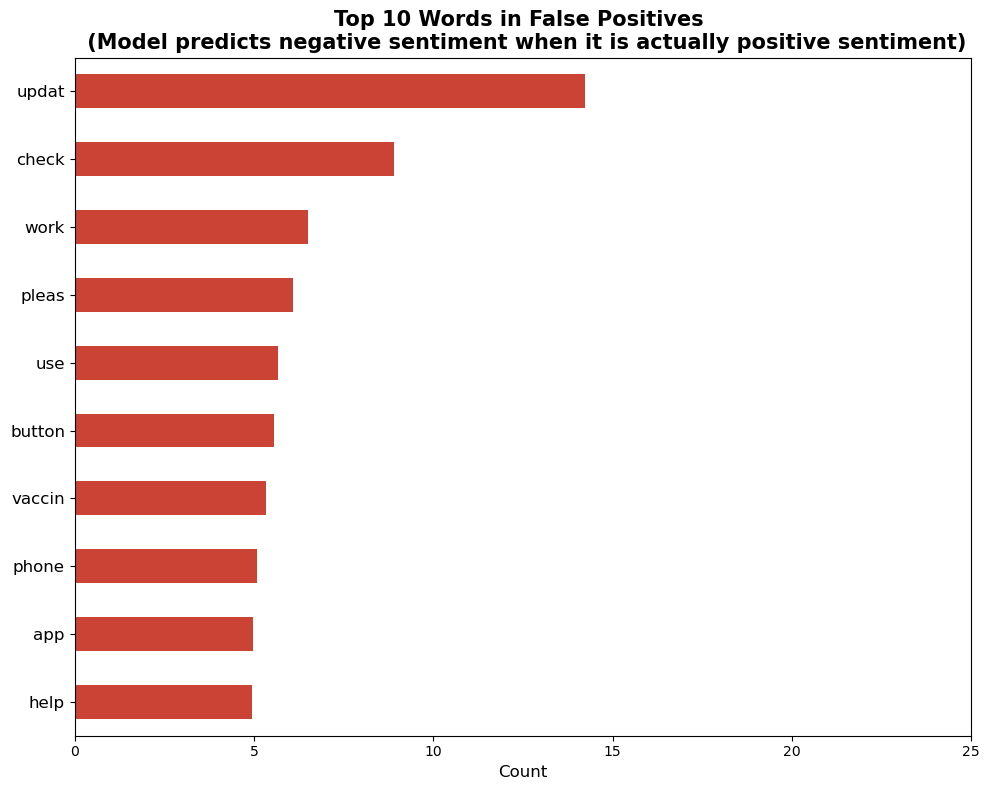

In [37]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=test,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#CB4335')

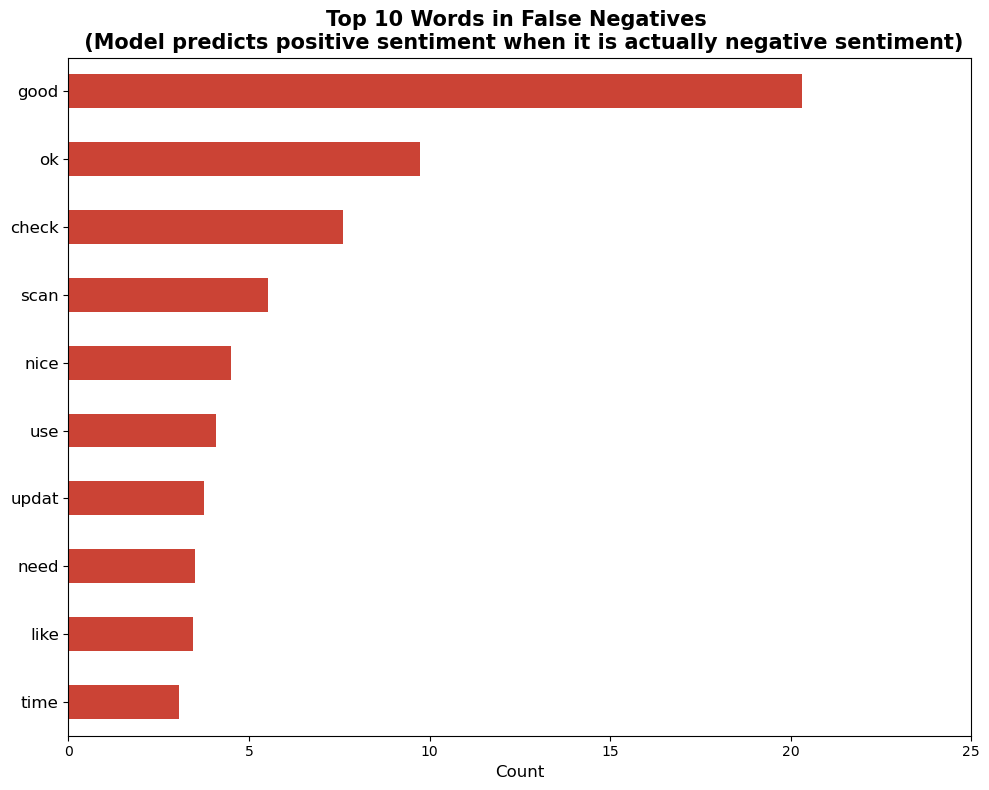

In [38]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=test,
             pred=0, 
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)", 
             color='#CB4335')

In [39]:
# False Negatives
fn = test[(test['correctly_classified']==0) & (test['pred']==0)][['content','content_stem','score']]

In [40]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

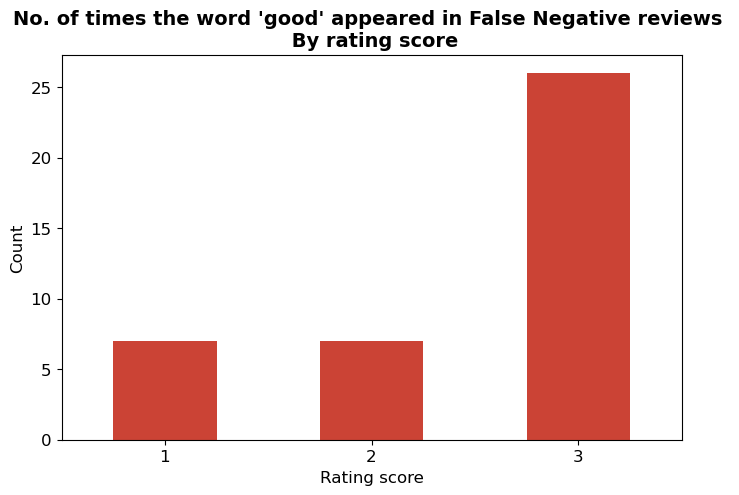

In [41]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#CB4335')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

In [42]:
# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','content_stem','score']].sort_values(by='score')

,content,content_stem,score
1427,Not good,good,1
1296,Not good,good,1
1116,this is good,good,1
1356,Good riddance,good riddanc,1
1023,All good for a Contact tracing app But can't MOH notify where the new cases are being reported ? Like I wanna go and shop in Mid Valley but I don't know whether they have been any new infection of Covid19 there ? Y'all should take a look at South Korean tracking app for Guidance,good contact trace moh notifi new case report like wanna go shop mid valley know whether new infect covid take look south korean track guidanc,1
1464,This is so good,good,1
600,"Dev team behind this app should be replaced with a more competent team. Not difficult to find good company with excellent track record, especially knowing it will have high load because of the free RM50. I bet this app is sourced and given to contacts rather than finding actual competent devs. OTP takes time, then says will process in batches. Register via Email doesn't work after pressing the link. Forgot password does not send anything to email. Not optimised for phones of all sizes. Terrible",dev team behind replac compet team difficult find good compani excel track record especi know high load free rm bet sourc given contact rather find actual compet dev otp take time say process batch regist via email work press link forgot password send anyth email optimis phone size terribl,1
1635,"There was an app update that we have to update our home address for the vaccination. Really upset that there was no media release or information in Google Play Store that we have to do this. Just app updated due to ""bug fixes."" This is absolutely irresponsible by the government and app developers. Good thing my friend told me. No wonder our vaccination rate is so low in Malaysia and we have high number of cases!!",updat updat home address vaccin realli upset media releas inform googl play store updat due bug fix absolut irrespons govern develop good thing friend told wonder vaccin rate low malaysia high number case,2
2307,"Why I cant check out from mysejahtera? After I update mysejahtera, it be like this. Actually, i more prefer like before this. Because, we can check out after we go another place. Like now, if we go others places its still check in while mean, we already go to anothers places. Please make a something good in this apps. If, you want make a traces on mysejahtera.. please make any traces of location where public people a locate. This is more functional I think for this time and make so easier to us.",cant check updat like actual prefer like check go anoth place like go other place still check mean alreadi go anoth place pleas make someth good app want make trace pleas make trace locat public peopl locat function think time make easier us,2
1625,"Poor auto focus since recent update on my mobile. Im unable to scan recenlty. no button to enable focus, a feature u need to enable click to focus. Since this development team is paid to create by govt. I hope they will stop using opensource zxing team's barcode scanner out of the box and use paid version or develop a good barcode scanner themself. This open source is good but u need to enhance it to adapt to various models of mobile. Esp auto focus which ur app is stuck using 1/2 lens i have",poor auto focu sinc recent updat mobil im unabl scan recenlti button enabl focu featur u need enabl click focu sinc develop team paid creat govt hope stop use opensourc zxing team barcod scanner box use paid version develop good barcod scanner themself open sourc good u need enhanc adapt variou model mobil esp auto focu ur stuck use len,2


Misclassification in the context of 'good' occurs when:
- User leaves a positive review but gives rates the app 3-stars. For example, "Good Application". These kinds of misclassifications are unavoidable and even a human will interpret it to be positive sentiment.
- User writes a review that mentions MySejahtera is 'good' in a one aspect, but indicates that there are other areas of improvement. Misclassifications of this sort can be reduced if the model was trained on more negative sentiment. Given the limited pool of negative reviews on Google Play, we can look into training the model on negative reviews from the Apple App Store in the future. 
- Given that we have removed stopwords like 'not' and 'no' during pre-processing, the word 'good' rather than 'not good' will be fed into the model. As these reviews typically contain very few words and do not provide feedback on how MySejahtera can improve the app experience, there are no dire consequences to such misclassifications.

## Deep Learning - Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) is a special kind of Recurrent Neural Network (RNN) capable of learning order dependence in sequence prediction problems. We will be using our own corpus embedding to build a deep network as pre-trained word embeddings like Work2vec and FastText will outperformed the model.

In [36]:
# Retrieve the X and y values from train and validation set, and store as list
# Exp 1(3 star as positive review)
X_train_list1 = X_train1
X_val_list1 = X_val1

y_train_list1 = y_train1
y_val_list1 = y_val1

# Exp 2(3 star as negative review) - store as list
X_train_list2 = X_train2
X_val_list2 = X_val2

y_train_list2 = y_train2
y_val_list2 = y_val2

In [37]:
X_train_list1

2458                                                                                                                                                                                                         cant updat timestamp updat date birth person detail section kkm nvr allow enter clinic pl advis
489                                                                                         keep mention updat keep press updat icon repeat also updat phone softwar seem work happen seamless pleas sort issu help access email address year old could kindli advic forum request write help desk thank sir
4467    need improv need anoth field enter temperatur meaning track meaningless unabl track bodi temperatur hope focu issu anoth thing cach clear histori also clear regardless check web app cach clear restor data back databas rest api graphql els would applic fashion noth els user get benefici initi
1779                                                                                             

Tokenization is the process of breaking down a text into words. Each of these smaller units paired with a unique number are called tokens. First, we will break the words in train set to be numeric token. Afterwards, the texts_to_sequences function helps to creates sequences of tokens representing each sentence.

In [38]:
# Limit the maximum word to avoid overfitting
max_words = 1500 

# Exp 1(3 star as positive review)
# Tokenize the data
tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(list(X_train_list1))
word_index = tokenizer1.word_index
#print(word_index)

# Convert the text to sequences
X_train_list1 = tokenizer1.texts_to_sequences(X_train_list1)
X_val_list1 = tokenizer1.texts_to_sequences(X_val_list1)
#print(X_train_list)
#print(X_val_list)

# Exp 2(3 star as negative review)
# Tokenize the data
tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(list(X_train_list2))
word_index2 = tokenizer2.word_index
#print(word_index)

# Convert the text to sequences
X_train_list2 = tokenizer2.texts_to_sequences(X_train_list2)
X_val_list2 = tokenizer2.texts_to_sequences(X_val_list2)
#print(X_train_list2)
#print(X_val_list2)

In [39]:
vocab_size = len(tokenizer1.word_index)+1
vocab_size2 = len(tokenizer2.word_index)+1

print('Vocabulary size:', vocab_size)
print('Vocabulary size:', vocab_size2)

Vocabulary size: 3829
Vocabulary size: 3855


Since every sentence in the data set has not the same number of words, we will use padding to ensure the sequences all in same shape. Maximum number of words will be defined at first, if a senntence is longer then the words will be drop.
Since the average length of negative review is 21 words and positive review is 15 words, we will set a maximum length of 30.

In [40]:
max_length = 30

X_train_padded1 = pad_sequences(X_train_list1, maxlen=max_length, padding='post',truncating='post')
X_val_padded1 = pad_sequences(X_val_list1, maxlen=max_length, padding='post',truncating='post')
#print(X_train_padded)
#print(X_val_padded)

X_train_padded2 = pad_sequences(X_train_list2, maxlen=max_length, padding='post',truncating='post')
X_val_padded2 = pad_sequences(X_val_list2, maxlen=max_length, padding='post',truncating='post')
#print(X_train_padded2)
#print(X_val_padded2)

Next, a network topology will be created. We will be using three-layer neural network, which consist of the follwing:
    1. 1st Layer - 16 nodes Bidirectional LSTM
    2. 2nd Layer - 8 nodes dense
    3. Output Layer - 1 node dense

In [41]:
# Instantiate model
model = Sequential()

# Add embedding layer, embed_dim:16
model.add(Embedding(vocab_size, 16, input_length=max_length))

# SpatialDropout1D performs variational dropout
model.add(SpatialDropout1D(0.75))

# Add LSTM
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.8, recurrent_dropout=0))) 

# Add a dense layer
model.add(Dense(8, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

model.add(GlobalAveragePooling1D())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Instantiate model
model2 = Sequential()

# Add embedding layer, embed_dim:16
model2.add(Embedding(vocab_size, 16, input_length=max_length)) 

# SpatialDropout1D performs variational dropout
model2.add(SpatialDropout1D(0.75))

# Add LSTM
model2.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.8, recurrent_dropout=0))) 

# Add a dense layer
model2.add(Dense(8, activation='relu'))

# Add output layer
model2.add(Dense(1, activation='sigmoid'))

model2.add(GlobalAveragePooling1D())

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            61264     
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 16)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 30, 32)           4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 30, 8)             264       
                                                                 
 dense_1 (Dense)             (None, 30, 1)             9         
                                                                 
 global_average_pooling1d (G  (None, 1)                0

The models and weights will be saved using the callback that we have created.

In [44]:
# Callback to save the models and weights
# Experiment 1
outputFolder = 'output'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath = outputFolder+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=False, save_weights_only=False,
    save_frequency=1)

# Experiment 2
outputFolder = 'output2'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath = outputFolder+"/model2-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_callback2 = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=False, save_weights_only=False,
    save_frequency=1)

In [45]:
%%time
# Fit the model and store it in the history object
history = model.fit(X_train_padded1, y_train_list1, epochs=50, batch_size=64, validation_data=(X_val_padded1, y_val_list1), callbacks=[checkpoint_callback])

Epoch 1/50
56/59 [===========================>..] - ETA: 0s - loss: 0.6708 - accuracy: 0.6016
Epoch 1: saving model to output\model-01-0.62.hdf5
59/59 [==============================] - 8s 36ms/step - loss: 0.6712 - accuracy: 0.6002 - val_loss: 0.6486 - val_accuracy: 0.6188
Epoch 2/50
57/59 [===========================>..] - ETA: 0s - loss: 0.6469 - accuracy: 0.6214
Epoch 2: saving model to output\model-02-0.62.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.6477 - accuracy: 0.6201 - val_loss: 0.6267 - val_accuracy: 0.6227
Epoch 3/50
57/59 [===========================>..] - ETA: 0s - loss: 0.6167 - accuracy: 0.6601
Epoch 3: saving model to output\model-03-0.71.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.6154 - accuracy: 0.6615 - val_loss: 0.5747 - val_accuracy: 0.7099
Epoch 4/50
56/59 [===========================>..] - ETA: 0s - loss: 0.5933 - accuracy: 0.6886
Epoch 4: saving model to output\model-04-0.72.hdf5
59/59 [=======================

Epoch 31/50
57/59 [===========================>..] - ETA: 0s - loss: 0.4867 - accuracy: 0.7648
Epoch 31: saving model to output\model-31-0.74.hdf5
59/59 [==============================] - 1s 18ms/step - loss: 0.4891 - accuracy: 0.7640 - val_loss: 0.5331 - val_accuracy: 0.7435
Epoch 32/50
57/59 [===========================>..] - ETA: 0s - loss: 0.4889 - accuracy: 0.7692
Epoch 32: saving model to output\model-32-0.74.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.4877 - accuracy: 0.7701 - val_loss: 0.5411 - val_accuracy: 0.7408
Epoch 33/50
57/59 [===========================>..] - ETA: 0s - loss: 0.4831 - accuracy: 0.7708
Epoch 33: saving model to output\model-33-0.74.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.4831 - accuracy: 0.7720 - val_loss: 0.5339 - val_accuracy: 0.7439
Epoch 34/50
56/59 [===========================>..] - ETA: 0s - loss: 0.4688 - accuracy: 0.7815
Epoch 34: saving model to output\model-34-0.74.hdf5
59/59 [===============

In [46]:
%%time
# Fit the model and store it in the history object
history2 = model2.fit(X_train_padded2, y_train_list2, epochs=50, batch_size=64, validation_data=(X_val_padded2, y_val_list2), callbacks=[checkpoint_callback2])

Epoch 1/50
57/59 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5669
Epoch 1: saving model to output2\model2-01-0.58.hdf5
59/59 [==============================] - 7s 38ms/step - loss: 0.6863 - accuracy: 0.5684 - val_loss: 0.6772 - val_accuracy: 0.5807
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.5973
Epoch 2: saving model to output2\model2-02-0.65.hdf5
59/59 [==============================] - 1s 20ms/step - loss: 0.6605 - accuracy: 0.5976 - val_loss: 0.6210 - val_accuracy: 0.6510
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6499
Epoch 3: saving model to output2\model2-03-0.70.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.6278 - accuracy: 0.6499 - val_loss: 0.5827 - val_accuracy: 0.7019
Epoch 4/50
56/59 [===========================>..] - ETA: 0s - loss: 0.6057 - accuracy: 0.6749
Epoch 4: saving model to output2\model2-04-0.73.hdf5
59/59 [===============

59/59 [==============================] - 1s 19ms/step - loss: 0.4793 - accuracy: 0.7746 - val_loss: 0.5076 - val_accuracy: 0.7722
Epoch 31/50
56/59 [===========================>..] - ETA: 0s - loss: 0.4699 - accuracy: 0.7782
Epoch 31: saving model to output2\model2-31-0.77.hdf5
59/59 [==============================] - 1s 19ms/step - loss: 0.4711 - accuracy: 0.7791 - val_loss: 0.5114 - val_accuracy: 0.7718
Epoch 32/50
57/59 [===========================>..] - ETA: 0s - loss: 0.4694 - accuracy: 0.7799
Epoch 32: saving model to output2\model2-32-0.77.hdf5
59/59 [==============================] - 1s 18ms/step - loss: 0.4710 - accuracy: 0.7781 - val_loss: 0.4999 - val_accuracy: 0.7705
Epoch 33/50
57/59 [===========================>..] - ETA: 0s - loss: 0.4800 - accuracy: 0.7670
Epoch 33: saving model to output2\model2-33-0.77.hdf5
59/59 [==============================] - 1s 18ms/step - loss: 0.4787 - accuracy: 0.7683 - val_loss: 0.5136 - val_accuracy: 0.7687
Epoch 34/50
57/59 [==============

Text(0.5, 0.98, 'Training and Validation Loss by Epoch')

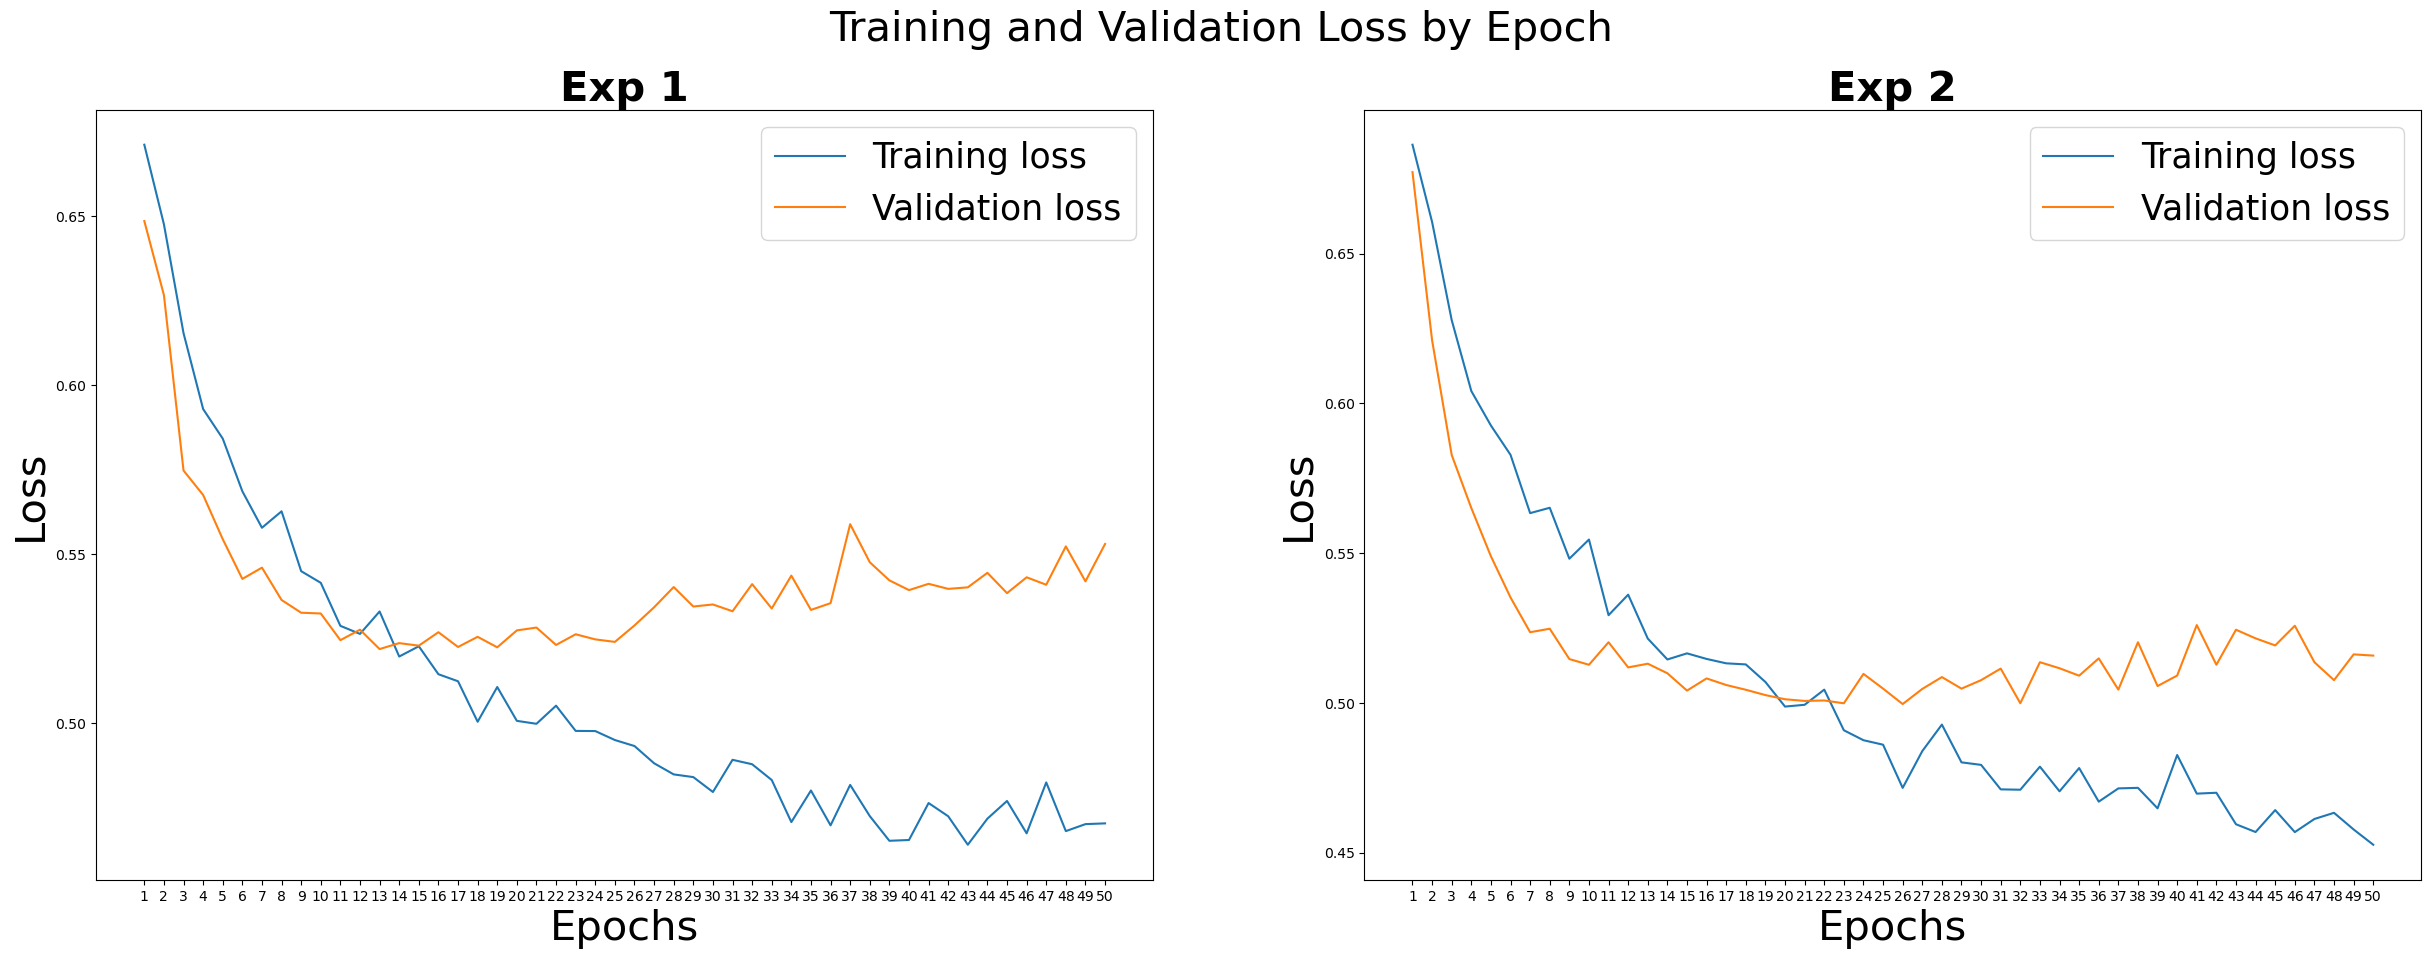

In [47]:
# Plot the training and validation loss by epoch - Exp 1
figure, axis = plt.subplots(1, 2,figsize=(30,10))
epochs = range(1,51)
axis[0].plot(epochs, history.history['loss'], label='Training loss')
axis[0].plot(epochs, history.history['val_loss'], label='Validation loss')
axis[0].set_title('Exp 1', size =30, weight='bold')
axis[0].set_xlabel('Epochs', size=30)
axis[0].set_ylabel('Loss', size=30)
axis[0].set_xticks(np.arange(1,51,1))
axis[0].legend(prop={'size': 25});

# Plot the training and validation loss by epoch - Exp 2
epochs = range(1,51)
axis[1].plot(epochs, history2.history['loss'], label='Training loss')
axis[1].plot(epochs, history2.history['val_loss'], label='Validation loss')
axis[1].set_title('Exp 2', size =30, weight='bold')
axis[1].set_xlabel('Epochs', size=30)
axis[1].set_ylabel('Loss', size=30)
axis[1].set_xticks(np.arange(1,51,1))
axis[1].legend(prop={'size': 25});

figure.suptitle('Training and Validation Loss by Epoch', fontsize= 30)

Text(0.5, 0.98, 'Training and Validation Accuracy by Epoch')

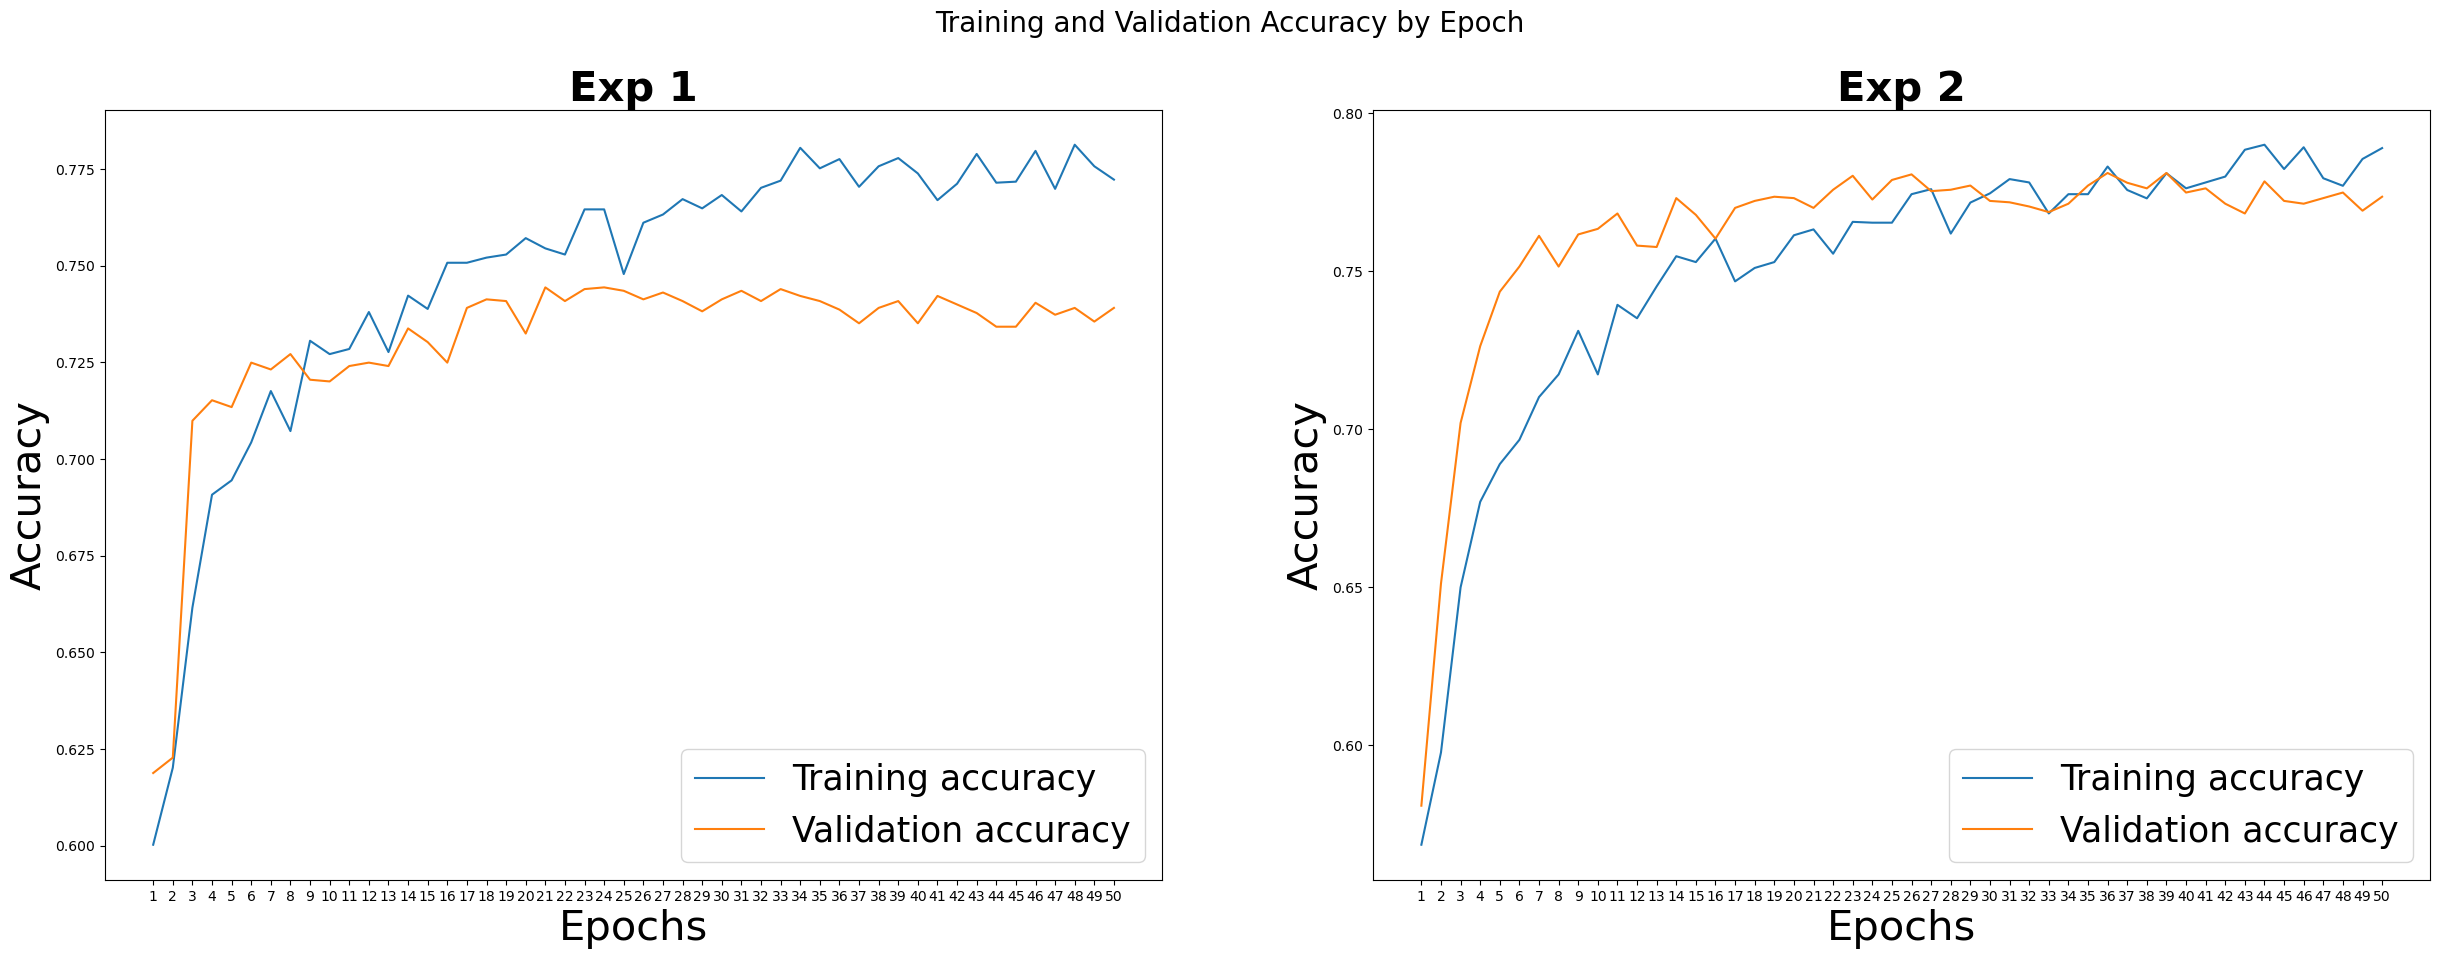

In [48]:
# Plot the training and validation accuracy by epoch - Exp 1
figure, axis = plt.subplots(1, 2, figsize=(30,10))
epochs = range(1,51)
axis[0].plot(epochs, history.history['accuracy'], label='Training accuracy')
axis[0].plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
axis[0].set_title('Exp 1', size=30, weight='bold')
axis[0].set_xlabel('Epochs', size=30)
axis[0].set_ylabel('Accuracy', size=30)
axis[0].set_xticks(np.arange(1,51,1))
axis[0].legend(prop={'size': 25});

# Plot the training and validation accuracy by epoch - Exp2
epochs = range(1,51)
axis[1].plot(epochs, history2.history['accuracy'], label='Training accuracy')
axis[1].plot(epochs, history2.history['val_accuracy'], label='Validation accuracy')
axis[1].set_title('Exp 2', size=30, weight='bold')
axis[1].set_xlabel('Epochs', size=30)
axis[1].set_ylabel('Accuracy', size=30)
axis[1].set_xticks(np.arange(1,51,1))
axis[1].legend(prop={'size': 25});

figure.suptitle('Training and Validation Accuracy by Epoch', fontsize= 20)

From the training and validation loss figure, the validation loss stagnant after 25th epoch and 22nd epochs respectively. Thus, the checked point model selected will be model-25 and model2-22 respectively.

### Loading a check-pointed model

In [73]:
# Load weights
model.load_weights('output/model-25-0.74.hdf5')

In [74]:
# Compile the model|
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
# Generate predictions on validation set
class_preds = (model.predict(X_val_padded1) > 0.5).astype(int)

71/71 [==============================] - 1s 4ms/step


In [76]:
val_preds = []

# Loop through the class prediction list and append the predictions to val_preds
for i in class_preds:
    val_preds.append(i[0])

# Convert val_preds to a series
val_preds = pd.Series(val_preds)

In [77]:
# Accuracy scores
print('Accuracy score on training set: ', model.evaluate(X_train_padded1, y_train_list1, verbose=0)[1])
print('Accuracy score on validation set: ', model.evaluate(X_val_padded1, y_val_list1, verbose=0)[1])
print('')

# Print classification report and confusion matrix for validation set
creport(y_val, val_preds, 'validation set')

Accuracy score on training set:  0.8117865920066833
Accuracy score on validation set:  0.7434763312339783

Classification report for validation set
              precision    recall  f1-score   support

           0       0.43      0.64      0.52       948
           1       0.60      0.40      0.48      1313

    accuracy                           0.50      2261
   macro avg       0.52      0.52      0.50      2261
weighted avg       0.53      0.50      0.50      2261




In [68]:
# Load weights
model2.load_weights('output2/model2-22-0.78.hdf5')

In [69]:
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# Generate predictions on validation set
class_preds = (model2.predict(X_val_padded1) > 0.5).astype(int)

71/71 [==============================] - 1s 4ms/step


In [71]:
val_preds2 = []

# Loop through the class prediction list and append the predictions to val_preds
for i in class_preds:
    val_preds2.append(i[0])

# Convert val_preds to a series
val_preds2= pd.Series(val_preds2)

In [78]:
# Accuracy scores
print('Accuracy score on training set: ', model2.evaluate(X_train_padded2, y_train_list2, verbose=0)[1])
print('Accuracy score on validation set: ', model2.evaluate(X_val_padded2, y_val_list2, verbose=0)[1])
print('')

# Print classification report and confusion matrix for validation set
creport(y_val2, val_preds2, 'validation set')

Accuracy score on training set:  0.8327581882476807
Accuracy score on validation set:  0.7757629156112671

Classification report for validation set
              precision    recall  f1-score   support

           0       0.41      0.24      0.30       948
           1       0.58      0.76      0.66      1313

    accuracy                           0.54      2261
   macro avg       0.50      0.50      0.48      2261
weighted avg       0.51      0.54      0.51      2261




Based on the results for both experiments, LSTM model has moderate accuracy but poor recall. This might be due to the nature of our dataset. The average length of review only about 15-21 words.

## Topic Modelling for Negative Sentiment

Next, we will use Gensim's LDA to identify the key pain points that dissatisfied customers are facing. 

Before running LDA, we will first perform a simple pre-processing by removing stopwords, lemmatizing and using SpaCy to only keep tokens that are nouns, adjectives, verbs or adverbs. This approach gave us more distinct topics than if we were to just rely on the same pre-processing approach as that used during classification modeling.

In [79]:
# Create a list of all the textual data from negative reviews
data = exp_dataset2[exp_dataset2['target']==1]['content'].values.tolist()
data

['Some buttons are unable to function. I am tired in trying to reinstall the app again and again. It brings alot of inconveniences, please fix it immediately. For example: when I tried to press the button to check-in, the screen remains unchanged. I understand the government is swamped under the current condition of our country, but a poorly-functional app has the risk to discourage the people to use it. Thank you.',
 'After updating to the latest version which enables downloading of digital certificate, I was happy that finally my Android phone gets to have such feature. However, when I try to open my digital certificate after downloading, "Permission was denied" is the only message that I get! It\'s been like this for few days. I log out and tried again, but the same message! Worst still, after emailing to helpdesk of this issue, there is no response at all (not even in junk folder) !! It\'s so frustrating!',
 'With the new tracking function automatically added into the app, it\'s re

In [80]:
# Assign NLTK's stopwords to stop_words
stop_words = stopwords.words('english')

# Include frequently occuring words like 'app' and 'MySejahtera' to the stopwords list. These words will not value add to our topics.
stop_words.extend(['app','MySJ', 'mysj', 'Covid','Covid-19','MySejahtera','COVID-19','pandemic','Bluetooth','mysejahtera'])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [81]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) 
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# Pre-processing text
data_ready = process_words(data)

In [82]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready) 

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # Number of topics
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.080*"check" + 0.032*"good" + 0.025*"button" + 0.025*"trace" + '
  '0.018*"update" + 0.017*"slow" + 0.016*"bluetooth" + 0.015*"location" + '
  '0.015*"work" + 0.014*"new"'),
 (1,
  '0.085*"update" + 0.024*"still" + 0.021*"status" + 0.018*"help" + '
  '0.017*"get" + 0.017*"booster" + 0.016*"late" + 0.014*"fix" + '
  '0.014*"already" + 0.013*"vaccination"'),
 (2,
  '0.034*"phone" + 0.028*"password" + 0.028*"try" + 0.026*"new" + '
  '0.026*"number" + 0.020*"help" + 0.019*"use" + 0.019*"reset" + 0.018*"time" '
  '+ 0.017*"say"')]


In [83]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formatting the table
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

C:\Users\queen\AppData\Local\Temp\ipykernel_12984\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\queen\AppData\Local\Temp\ipykernel_12984\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5635,"check, good, button, trace, update, slow, bluetooth, location, work, new","[button, unable, function, tired, try, reinstall, bring, alot, inconvenience, fix, immediately, example, try, press, button, check, screen, remain, unchanged, understand, government, swamp, current, condition, country, poorly, functional, risk, discourage, people, use, thank]"
1,1,1,0.5383,"update, still, status, help, get, booster, late, fix, already, vaccination","[update, late, version, enable, download, digital, certificate, happy, finally, android, phone, get, feature, however, try, open, digital, certificate, download, permission, deny, message, get, day, log, try, message, bad, still, email, helpdesk, issue, response, even, junk, folder, frustrating]"
2,2,0,0.7345,"check, good, button, trace, update, slow, bluetooth, location, work, new","[new, tracking, function, automatically, add, really, frustrating, even, turn, bluetooth, location, yet, still, get, stuck, click, allow, show, incomplete, process, user, turn, bluetooth, location, even, already, turn, well, let, user, shift, manual, check, check, function, least, record, clear, manually]"
3,3,2,0.4662,"phone, password, try, new, number, help, use, reset, time, say","[good, bug, everytime, use, qr, scanner, phone, volume, automatically, go, full, blast, everytime, watch, video, volume, full, blast, permission, volume, update, still, problem, use, check, medium, volume, shoot, full, blast, notification, whatsoever, indicate, happen]"
4,4,0,0.7623,"check, good, button, trace, update, slow, bluetooth, location, work, new","[late, update, trace, utterly, ridiculous, still, continue, support, help, make, sure, work, interaction, record, wife, need, go, even, sit, dining, room, family, member, phone, detect, think, previous, check, check, feature, already, good, enough, detect, possible, contact, premise, design, hourly, notification, remind, people, case, forgot, check, premise, still, name, location, option, choose, checkout, accurate, record, contact, trace, bluetooth, trace, good, idea, check, make, work, first, personally, think, turn, bluetooth, time, drain, lot, juice, phone, agree, constant, permanent, notification, annoying, serve, purpose]"


In [84]:
# Keywords of each dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show the 3 topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9807,"check, good, button, trace, update, slow, bluetooth, location, work, new","[developer, think, ppl, high, spec, phone, high, capacity, battery, build, use, potato, phone, small, battery, turn, bluetooth, thing, nonsense, drain, phone, battery, much, interfere, wifi, cause, wifi, slow, use, internet, home, need, wireless, headset, also, use, bluetooth, function]"
1,1,0.9760,"update, still, status, help, get, booster, late, fix, already, vaccination","[quarantine, status, still, close, contact, covid, status, health, assessment, update, last, update, report, helpdesk, still, change, already, uninstall, install, still, today, second, dose, status, still, change, take, vaccine]"
2,2,0.9773,"phone, password, try, new, number, help, use, reset, time, say","[register, log, use, enter, click, forgot, reset, receive, sm, reset, follow, link, take, min, time, reset, password, expire, try, time, manage, reset, logon, use, new, password, say, unauthorized, spend, min, get]"


C:\Users\queen\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\queen\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\queen\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\queen\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

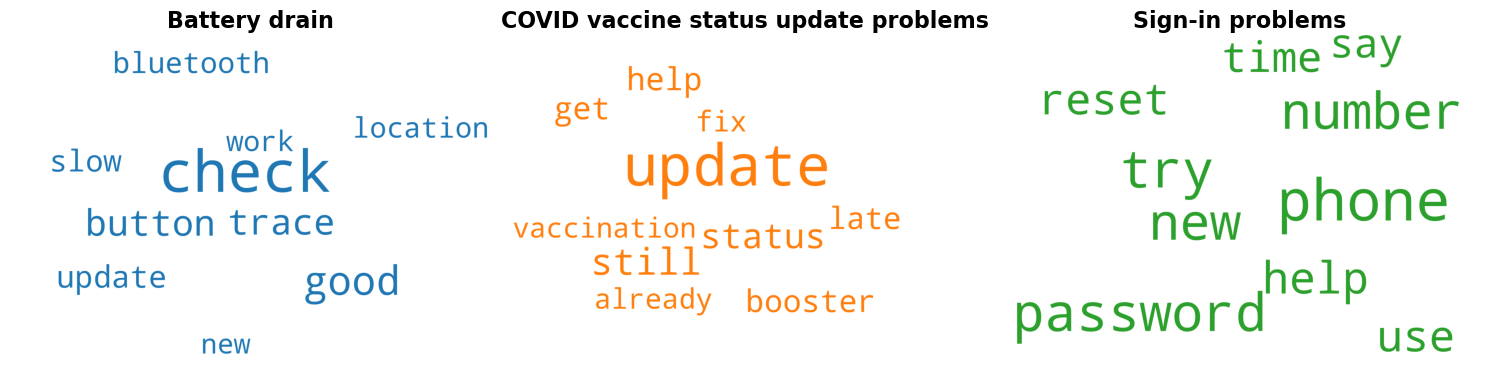

In [85]:
# Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True, sharey=True)

topic_names = ['Battery drain', 'COVID vaccine status update problems', 'Sign-in problems']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [86]:
# Visualisation of the topics estimated using LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\queen\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.209231 -0.138864       1        1  39.515097
0     -0.231463 -0.102357       2        1  34.143020
2      0.022232  0.241222       3        1  26.341884, topic_info=         Term         Freq        Total Category  logprob  loglift
3       check  2019.000000  2019.000000  Default  30.0000  30.0000
58     update  2938.000000  2938.000000  Default  29.0000  29.0000
90       good   811.000000   811.000000  Default  28.0000  28.0000
346  password   553.000000   553.000000  Default  27.0000  27.0000
55      phone   796.000000   796.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
145      time   345.344426   676.254561   Topic3  -4.0359   0.6620
120      help   382.300120   896.137172   Topic3  -3.9342   0.4821
44        get   267.066602   852.918212   Topic3  -4.2929   0.1728
33        day   144.433282   378.030388   Topic3  -4.9076   0.3719
57      still   186.235836   933.212062   Topic3  -4.6534  -0.2776

[173 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
250       1  0.003817   account
250       2  0.003817   account
250       3  0.992404   account
828       1  0.005091  activate
828       2  0.987570  activate
...     ...       ...       ...
149       2  0.641577      work
149       3  0.072791      work
530       1  0.015186     wrong
530       2  0.015186     wrong
530       3  0.971901     wrong

[396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

We can conclude that the 3 topics are rather distinct as the bubbles are far away from one another on the intertopic distance map. The bar chart on the right represents the individual terms that are the most useful for interpreting a selected topic.   

We will be browsing through some of the negative reviews in our dataset to better contextualise the 3 pain points that the LDA model has identified.

In [87]:
# Browse through the reviews that contain the top words related to each topic
exp_dataset2[(exp_dataset2['target']==1) & (exp_dataset2['content'].str.contains('payment'))]['content']

160    I am giving 1 star because opening location and bluetooth at the same time to trace is super redundant. Why not just have location on and that's it? And if you're worried about people not checking out, just make a notification that they can't remove until they check out. Or make it like PLUS highway's toll payment style: check in one qr, check out one qr
Name: content, dtype: object

### Export model for Deployment purpose

In [43]:
models = [(model, X_val, y_val, X_test, y_test) 
          for exp_type, result_csv, vectorizer_classifier_name, model, time_taken, 
          X_train, y_train, X_val, y_val, X_test, y_test 
           in fitted_models if vectorizer_classifier_name == "tvec_mnb" and exp_type == "exp2"]
model, X_val, y_val, X_test, y_test = models[0]

In [44]:
from joblib import dump, load
dump(model, 'mnb_model.joblib')

['mnb_model.joblib']